# Designing an Efficient and Robust Road-Based Public Transportation Network For Metro Manila

## Author: [Gio Anton Velez](gio_velez@dlsu.edu.ph)

---
The MIT License (MIT)

Copyright (c) 2015 Michael Lees, Debraj Roy

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

---

## Introduction

This small collection of Jupyter (IPython) notebooks serves as test experiments for the validation and experimentation of our thesis. This is intended for those who are interested in seeing the results and analysis of the experiments of the three major modules of the study namely the <b>Stop Layout Generator, Route Generator and the Network Optimizer<b> modules



## Load the Datasets

We first import the required python packages to make sure everything runs smoothly and there are no dependency conflicts as we move on throughout the experiment


In [83]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [82]:
import pandas as pd
import folium
import numpy as np
import json
import randomcolor
import random
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import copy
import sys
from tqdm import tqdm
import matplotlib.patches as mpatches #for legends in the graph
%matplotlib inline  



## Lattice Layout Datasets

In [26]:
lattice_makati_50_350 = "lattice/lattice_makati_50_350.txt"
lattice_makati_250_350 = "lattice/lattice_makati_250_350.txt"
lattice_makati_500_500 = "lattice/lattice_makati_500_500.txt"
lattice_manila_50_350 = "lattice/lattice_manila_50_350.txt"
lattice_manila_250_350 = "lattice/lattice_manila_250_350.txt"
lattice_manila_500_500 = "lattice/lattice_manila_500_500.txt"
lattice_paranaque_50_350 = "lattice/lattice_paranaque_50_350.txt"
lattice_paranaque_250_350 = "lattice/lattice_paranaque_250_350.txt"
lattice_paranaque_500_500 = "lattice/lattice_paranaque_500_500.txt"
lattice_quezon_50_350 = "lattice/lattice_quezon_50_350.txt"
lattice_quezon_250_350 = "lattice/lattice_quezon_250_350.txt"
lattice_quezon_500_500 = "lattice/lattice_quezon_500_500.txt"

## Random Layout Datasets

In [27]:
random_makati_50_350 = "random/random_makati_50_350.txt"
random_makati_250_350 = "random/random_makati_250_350.txt"
random_makati_500_500 = "random/random_makati_500_500.txt"
random_manila_50_350 = "random/random_manila_50_350.txt"
random_manila_250_350 = "random/random_manila_250_350.txt"
random_manila_500_500 = "random/random_manila_500_500.txt"
random_paranaque_50_350 = "random/random_paranaque_50_350.txt"
random_paranaque_250_350 = "random/random_paranaque_250_350.txt"
random_paranaque_500_500 = "random/random_paranaque_500_500.txt"
random_quezon_50_350 = "random/random_quezon_50_350.txt"
random_quezon_250_350 = "random/random_quezon_250_350.txt"
random_quezon_500_500 = "random/random_quezon_500_500.txt"

## N-Blob Datasets (1 Predefined Mean)

In [35]:
nblob1_makati_50_350 = "nblob1/nblob1_makati_50_350.txt"
nblob1_makati_250_350 = "nblob1/nblob1_makati_250_350.txt"
nblob1_makati_500_500 = "nblob1/nblob1_makati_500_500.txt"
nblob1_manila_50_350 = "nblob1/nblob1_manila_50_350.txt"
nblob1_manila_250_350 = "nblob1/nblob1_manila_250_350.txt"
nblob1_manila_500_500 = "nblob1/nblob1_manila_500_500.txt"
nblob1_paranaque_50_350 = "nblob1/nblob1_paranaque_50_350.txt"
nblob1_paranaque_250_350 = "nblob1/nblob1_paranaque_250_500.txt"
nblob1_paranaque_500_500 = "nblob1/nblob1_paranaque_500_500.txt"
nblob1_quezon_50_350 = "nblob1/nblob1_quezon_50_350.txt"
nblob1_quezon_250_350 = "nblob1/nblob1_quezon_250_350.txt"
nblob1_quezon_500_500 = "nblob1/nblob1_quezon_500_500.txt"

## N-Blob Datasets (2 Predefined Means)

In [29]:
nblob2_makati_500_500 = "nblob2/nblob2_makati_500_500.txt"
nblob2_manila_500_500 = "nblob2/nblob2_manila_500_500.txt"
nblob2_paranaque_500_500 = "nblob2/nblob2_paranaque_500_500.txt"
nblob2_quezon_500_500 = "nblob2/nblob2_quezon_500_500.txt"

## Importing the File to a Data Frame

In [30]:
def create_layout_dataframe(fname):
    pd.options.mode.chained_assignment = None  # default='warn'
    df = pd.read_csv(fname,delim_whitespace = True,header=None, engine='python')
    df_stop = df[df[0] == "stop,"]
    df_stop.columns = ['Type', 'Lat', 'Lon','Color']
    df_route = df[df[0] == "route,"]
    df_route = df_route.dropna(axis=1,how='all')  
    df_route.columns = ['Type', 'Path']

    df_stop["Type"] = [x.replace(',', '') for x in df_stop["Type"]]
    df_stop["Lat"] = [x.replace(',', '') for x in df_stop["Lat"]]
    df_stop["Lon"] = [x.replace(',', '') for x in df_stop["Lon"]]
    
    df_route["Type"] = [x.replace(',', '') for x in df_route["Type"]]

    return df_stop,df_route

def dist(x,y):   
    return np.sqrt(np.sum((x-y)**2))

def calculate_avg_OD_distance(df_stop):
    pass


# Stop Generator

## Preparing Map Display

In [94]:
def create_stop_map(df_stop):
    lat = df_stop.iloc[0]['Lat']
    lon = df_stop.iloc[0]['Lon']
    map_osm = folium.Map(location=[lat, lon], tiles='Stamen Toner',zoom_start=13)

    for row in df_stop.itertuples():
        folium.RegularPolygonMarker(location=[float(row.Lat),float(row.Lon)], fill_color=row.Color, number_of_sides=8, radius=10).add_to(map_osm)
    return map_osm

def create_route_map(osm_map, df_route):
    for row in df_route.iterrows():
            string_path = df_route.Path
            break

    for row in string_path:
        path_coords_json = json.loads(row)
        points = []
        for coordinates in path_coords_json:
            points.append(tuple([coordinates[0],coordinates[1]]))
        rand_color = randomcolor.RandomColor()
        folium.PolyLine(points, color=str(rand_color.generate()[0]), weight=2.5, opacity=1).add_to(osm_map)

    return osm_map

def generate_layout_features(layout):
    df_stop, df_route = create_layout_dataframe(layout)
    osm_map = create_stop_map(df_stop)
    
    return df_stop, df_route, osm_map

def wrap(features):
    feature_wrapper = []
    df_stop, df_route, osm_map = features
    feature_wrapper.append(df_stop)
    feature_wrapper.append(df_route)
    feature_wrapper.append(osm_map)
    return feature_wrapper
    
    

## Makati

## Lattice Layout

In [107]:
df_stop_lattice_makati_50_350_wrapper = wrap(generate_layout_features(lattice_makati_50_350))
df_stop_lattice_makati_250_350_wrapper = wrap(generate_layout_features(lattice_makati_250_350))
df_stop_lattice_makati_500_500_wrapper = wrap(generate_layout_features(lattice_makati_500_500))

df_stop_lattice_manila_50_350_wrapper = wrap(generate_layout_features(lattice_manila_50_350))
df_stop_lattice_manila_250_350_wrapper = wrap(generate_layout_features(lattice_manila_250_350))
df_stop_lattice_manila_500_500_wrapper = wrap(generate_layout_features(lattice_manila_500_500))

df_stop_lattice_paranaque_50_350_wrapper = wrap(generate_layout_features(lattice_paranaque_50_350))
df_stop_lattice_paranaque_250_350_wrapper = wrap(generate_layout_features(lattice_paranaque_250_350))
df_stop_lattice_paranaque_500_500_wrapper = wrap(generate_layout_features(lattice_paranaque_500_500))
                                         
df_stop_lattice_quezon_50_350_wrapper = wrap(generate_layout_features(lattice_quezon_50_350))
df_stop_lattice_quezon_250_350_wrapper = wrap(generate_layout_features(lattice_quezon_250_350))
df_stop_lattice_quezon_500_500_wrapper = wrap(generate_layout_features(lattice_quezon_500_500))


## Random Layout

In [108]:
df_stop_random_makati_50_350_wrapper = wrap(generate_layout_features(random_makati_50_350))
df_stop_random_makati_250_350_wrapper = wrap(generate_layout_features(random_makati_250_350))
df_stop_random_makati_500_500_wrapper = wrap(generate_layout_features(random_makati_500_500))

df_stop_random_manila_50_350_wrapper = wrap(generate_layout_features(random_manila_50_350))
df_stop_random_manila_250_350_wrapper = wrap(generate_layout_features(random_manila_250_350))
df_stop_random_manila_500_500_wrapper = wrap(generate_layout_features(random_manila_500_500))

df_stop_random_paranaque_50_350_wrapper = wrap(generate_layout_features(random_paranaque_50_350))
df_stop_random_paranaque_250_350_wrapper = wrap(generate_layout_features(random_paranaque_250_350))
df_stop_random_paranaque_500_500_wrapper = wrap(generate_layout_features(random_paranaque_500_500))

df_stop_random_quezon_50_350_wrapper = wrap(generate_layout_features(random_quezon_50_350))
df_stop_random_quezon_250_350_wrapper = wrap(generate_layout_features(random_quezon_250_350))
df_stop_random_quezon_500_500_wrapper = wrap(generate_layout_features(random_quezon_500_500))


## N-blob (1 Predefined Mean/CBD)

In [109]:
df_stop_nblob1_makati_50_350_wrapper = wrap(generate_layout_features(nblob1_makati_50_350))
df_stop_nblob1_makati_250_350_wrapper = wrap(generate_layout_features(nblob1_makati_250_350))
df_stop_nblob1_makati_500_500_wrapper = wrap(generate_layout_features(nblob1_makati_500_500))

df_stop_nblob1_manila_50_350_wrapper = wrap(generate_layout_features(nblob1_manila_50_350))
df_stop_nblob1_manila_250_350_wrapper = wrap(generate_layout_features(nblob1_manila_250_350))
df_stop_nblob1_manila_500_500_wrapper = wrap(generate_layout_features(nblob1_manila_500_500))

df_stop_nblob1_paranaque_50_350_wrapper = wrap(generate_layout_features(nblob1_paranaque_50_350))
df_stop_nblob1_paranaque_250_350_wrapper = wrap(generate_layout_features(nblob1_paranaque_250_350))
df_stop_nblob1_paranaque_500_500_wrapper = wrap(generate_layout_features(nblob1_paranaque_500_500))

df_stop_nblob1_quezon_50_350_wrapper = wrap(generate_layout_features(nblob1_quezon_50_350))
df_stop_nblob1_quezon_250_350_wrapper = wrap(generate_layout_features(nblob1_quezon_250_350))
df_stop_nblob1_quezon_500_500_wrapper = wrap(generate_layout_features(nblob1_quezon_500_500))


## N-blob (2 Predefined Means/CBDs)

In [110]:
df_stop_nblob2_makati_500_500_wrapper = wrap(generate_layout_features(nblob2_makati_500_500))

df_stop_nblob2_manila_500_500_wrapper = wrap(generate_layout_features(nblob2_manila_500_500))

df_stop_nblob2_paranaque_500_500_wrapper = wrap(generate_layout_features(nblob2_paranaque_500_500))

df_stop_nblob2_quezon_500_500_wrapper = wrap(generate_layout_features(nblob2_quezon_500_500))


## Route Generator Analysis with NetworkX

In [111]:
def generate_route_generator_analytics(df_stop,df_route, fraction_of_nodes_to_remove):
    
    route_network_list = []
    
    route_network = create_route_network(df_route)
    NetworkSize = len(route_network.nodes()) #network size to use in experiments
    num_removals = int(fraction_of_nodes_to_remove * NetworkSize) #number of nodes to remove
    
    nx.draw(route_network)
    plt.show()
    route_network_list.append(route_network)
    orig_route_network = copy.deepcopy(route_network_list)
    
    print (all_network_statistics(route_network_list))
    route_ave_diameters, route_ave_path_lengths, route_ave_S = experiments(route_network_list, num_removals)
    plot_analytics(NetworkSize, num_removals, orig_route_network, route_ave_diameters,route_ave_path_lengths, route_ave_S)
    
    
    
def create_route_network(df_route):
    route_network = nx.Graph()
    for row in df_route.iterrows():
                string_path = df_route.Path
                break
    for row in string_path:
        path_coords_json = json.loads(row)
        points = []

        i = 0
        for coordinates in path_coords_json:
            if(i == 0) :
                edge_1 = (float(coordinates[0]),float(coordinates[1]))
            elif(i == len(path_coords_json) - 1):
                edge_2 = (float(coordinates[0]),float(coordinates[1]))  
            i = i + 1

        route_network.add_edge(edge_1,edge_2)
    
    return route_network

def fail(G): #a python function that will remove a random node from the graph G
    n = random.choice(G.nodes())  #pick a random node
    G.remove_node(n) # remove that random node, attached edges automatically removed.
    
def attack_degree(G): #remove node with maximum degree
    degrees = G.degree() # get dcitonary where key is node id, value is degree
    max_degree = max(degrees.values()) # find maximum degree value from all nodes
    max_keys = [k for k,v in degrees.items() if v==max_degree] #get all nodes who have the maximum degree (may be more than one)
    G.remove_node(max_keys[0]) #remove just the first node with max degree, we will remove others next
    
def attack_betweenness(G): #note - not currently used, but try it!
    betweenness = nx.betweenness_centrality(G) # get dictionary where key is node id and value is betweenness centrality
    max_betweenenss = max(betweenness.values()) # find maximum degree value from all nodes
    max_keys = [k for k,v in betweenness.items() if v==max_betweenness] #get all nodes who have the maximum degree (may be more than one)
    G.remove_node(max_keys[0]) #remove just the first node with max degree, we will remove others next
    
    
def diameter_ave_path_length(G):
    # We create our own function to do this so things are slightly faster, 
    # we can calculate diameter and avg path length at the same time
    max_path_length = 0
    total = 0.0
    for n in G: #iterate over all nodes
        path_length=nx.single_source_shortest_path_length(G, n) # generate shortest paths from node n to all others
        total += sum(path_length.values()) #total of all shortest paths from n
        if max(path_length.values()) > max_path_length: #keep track of longest shortest path we see.
            max_path_length = max(path_length.values())         
    try:
        avg_path_length = total / (G.order()*(G.order() - 1))
    except ZeroDivisionError:
        avg_path_length = 0.0
    return max_path_length, avg_path_length

def all_network_statistics(nw_list): 
    # a function that takes in a list of networks and returns 3 lists of same length listing the diameter, average 
    # path length and giant component size for all the networks
    diameters = []
    path_lengths = []
    S = []
    for n in nw_list:
        d,l,s = a_network_statistics(n)
        diameters.append(d)
        path_lengths.append(l)
        S.append(s)
    return (diameters, path_lengths, S)

def a_network_statistics(n):
    
    Gcc=sorted(nx.connected_component_subgraphs(n), key = len, reverse=True)
    G0=Gcc[0]
    d,l = diameter_ave_path_length(G0)
    s = float(G0.order()) / float(len(n.nodes()))
    return d,l,s

def experiments(networks, removals, run_fail=True, measure_every_X_removals=20):
    # the below list will record the average statistic for all networks, a new entry in the list is added after each fail
    ave_diameters = []
    ave_path_lengths = []
    ave_S = []
    sys.stderr.write("---- Starting Experiments ---- \n")
    sys.stderr.flush()
    for x in tqdm(range(removals)):                    
        for n in networks:
            if run_fail:
                fail(n)
            else:
                attack_degree(n)
        if x % measure_every_X_removals == 0:            
            d, l, s = all_network_statistics(networks)
            ave_diameters.append(np.mean(d))
            ave_path_lengths.append(np.mean(l))
            ave_S.append(np.mean(s))
    sys.stderr.write("---- Experiments Finished ---- \n")
    sys.stderr.flush()
    return ave_diameters, ave_path_lengths, ave_S

def plot_analytics(NetworkSize, num_removals, orig_route_network, route_ave_diameters, route_ave_path_lengths, route_ave_S):
    #plotting stuff...
    #values on x axis
    xvalues = [(float(x)/float(NetworkSize)) * 20 for x in range(len(route_ave_diameters))]

    #size of figure to plot
    fig_size= [18,13]

    #tell matplotlib some key parameters
    plt.rcParams.update({'font.size': 20, "figure.figsize": fig_size})

    # Plot diameters of both graphs.
    plt.plot(xvalues, route_ave_diameters, '--or')

    #plot legend details
    red_patch = mpatches.Patch(color='red', label='RN')
    # blue_patch = mpatches.Patch(color='blue', label='BA')
    plt.legend(handles=[red_patch])

    #set x and y labels of plots, and define plot title
    plt.xlabel('f')
    plt.ylabel('diameter')
    plt.title('Failures on Route Network size ' + str(NetworkSize))

    #display the plot to screen
    plt.show()
    
    # Plot average path length
    plt.plot(xvalues, route_ave_path_lengths, '--or')
    red_patch = mpatches.Patch(color='red', label='RN')
    plt.legend(handles=[red_patch])
    plt.xlabel('f')
    plt.ylabel('<l>')
    plt.title('Failures on Route Network Size ' + str(NetworkSize))
    plt.show()
    
    # Plot fraction of nodes in giant component
    plt.plot(xvalues, route_ave_S, '--or')
    red_patch = mpatches.Patch(color='red', label='RN')
    plt.legend(handles=[red_patch])
    plt.xlabel('f')
    plt.ylabel('S')
    plt.title('Failures on Route Network Size ' + str(NetworkSize))
    plt.show()
    
    route_network_list = copy.deepcopy(orig_route_network)
    route_ave_diameters, route_ave_path_lengths, route_ave_S = experiments(route_network_list, num_removals, run_fail = False)
    print ("--Experiments Finished--")
    
    #plotting stuff...
    #values on x axis
    xvalues = [(float(x)/float(NetworkSize)) * 20 for x in range(len(route_ave_diameters))]

    #size of figure to plot
    fig_size= [18,13]

    #tell matplotlib some key parameters
    plt.rcParams.update({'font.size': 20, "figure.figsize": fig_size})

    # Plot diameters of both graphs.
    plt.plot(xvalues, route_ave_diameters, '--or')

    #plot legend details
    red_patch = mpatches.Patch(color='red', label='RN')
    # blue_patch = mpatches.Patch(color='blue', label='BA')
    plt.legend(handles=[red_patch])

    #set x and y labels of plots, and define plot title
    plt.xlabel('f')
    plt.ylabel('diameter')
    plt.title('Attack on Route Network Size ' + str(NetworkSize))

    #display the plot to screen
    plt.show()
    
    # Plot average path length
    plt.plot(xvalues, route_ave_path_lengths, '--or')
    red_patch = mpatches.Patch(color='red', label='RN')
    plt.legend(handles=[red_patch])
    plt.xlabel('f')
    plt.ylabel('<l>')
    plt.title('Attack on Route Network Size ' + str(NetworkSize))
    plt.show()
    
    # Plot fraction of nodes in giant component
    plt.plot(xvalues, route_ave_S, '--or')
    red_patch = mpatches.Patch(color='red', label='RN')
    plt.legend(handles=[red_patch])
    plt.xlabel('f')
    plt.ylabel('S')
    plt.title('Attack on Route Network Size ' + str(NetworkSize))
    plt.show()
    
    



In [117]:
df_stop, df_route, osm_map = df_stop_lattice_makati_500_500_wrapper
create_route_map(osm_map,df_route)

c:\users\gio\appdata\local\programs\python\python35\lib\site-packages\networkx\drawing\nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
c:\users\gio\appdata\local\programs\python\python35\lib\site-packages\networkx\drawing\nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
c:\users\gio\appdata\local\programs\python\python35\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
c:\users\gio\appdata\local\programs\python\python35\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: 

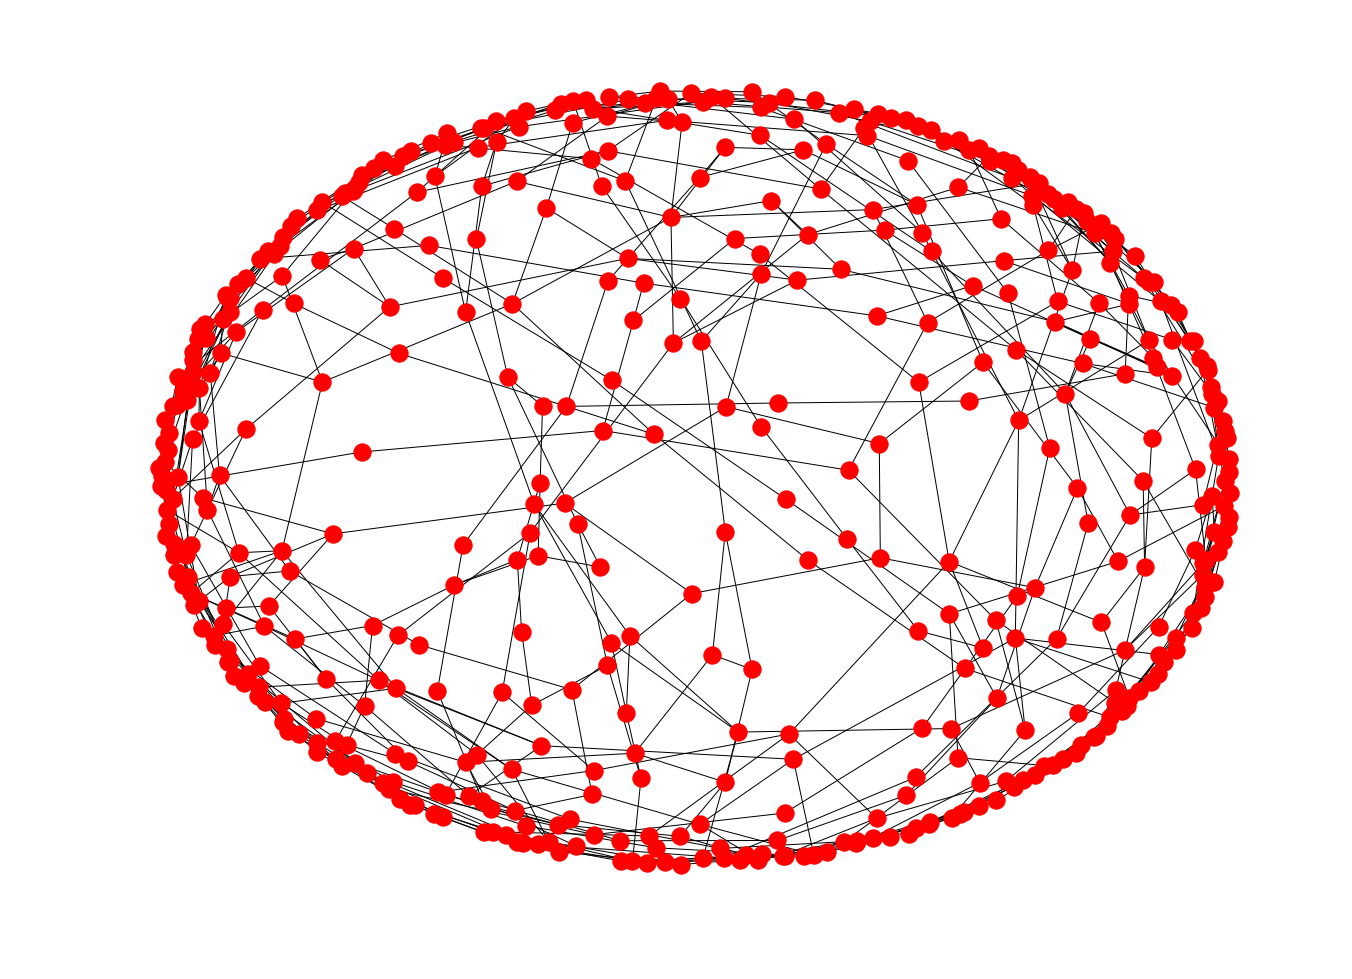

([64], [15.001994703141238], [1.0])


---- Starting Experiments ---- 
100%|███████████████████████████████████████████████████████████████████████████████| 464/464 [00:01<00:00, 293.48it/s]
---- Experiments Finished ---- 


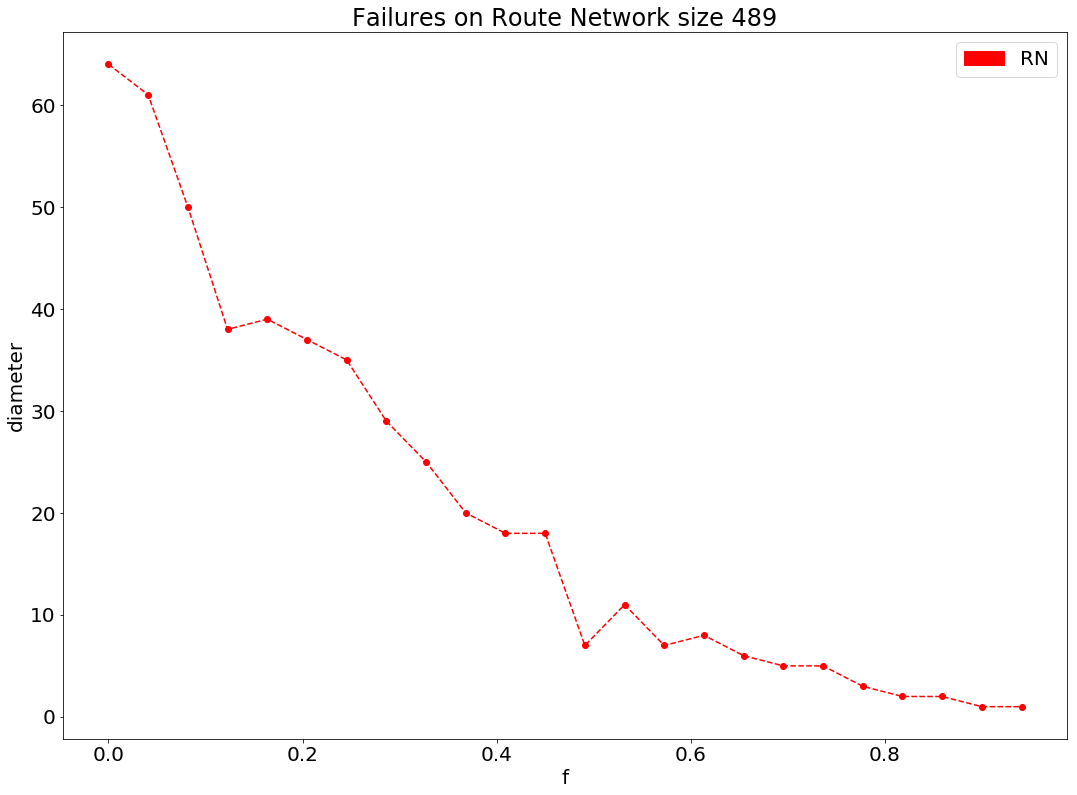

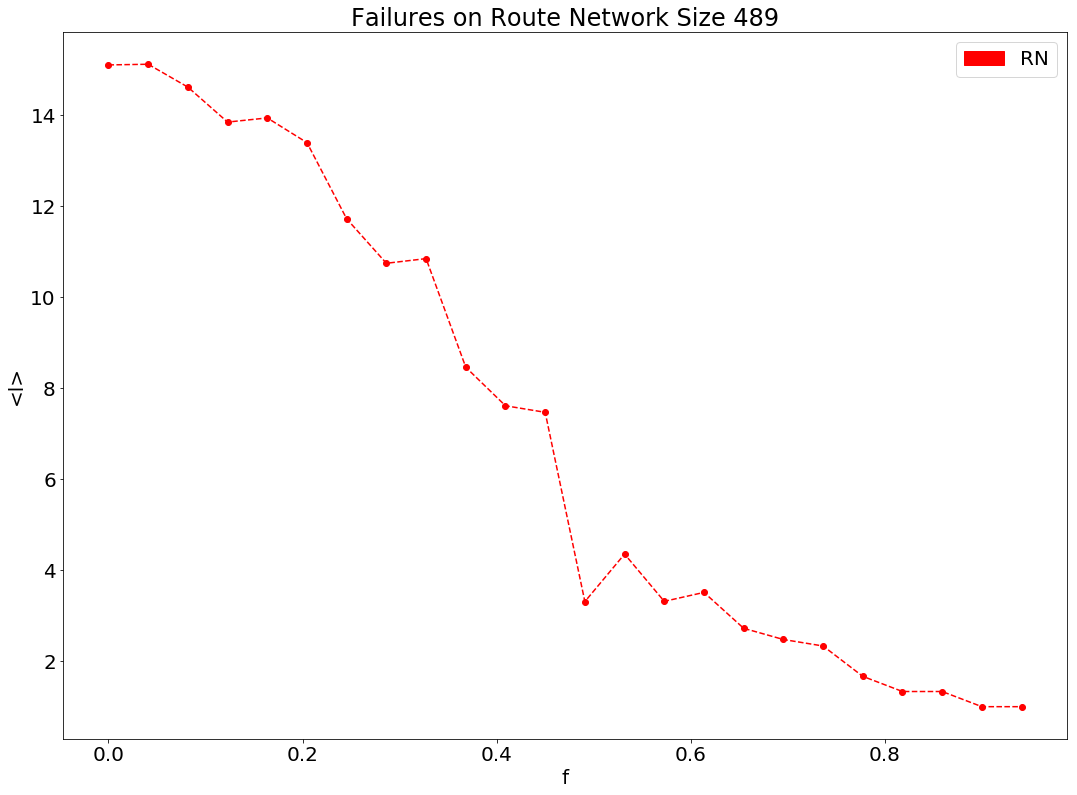

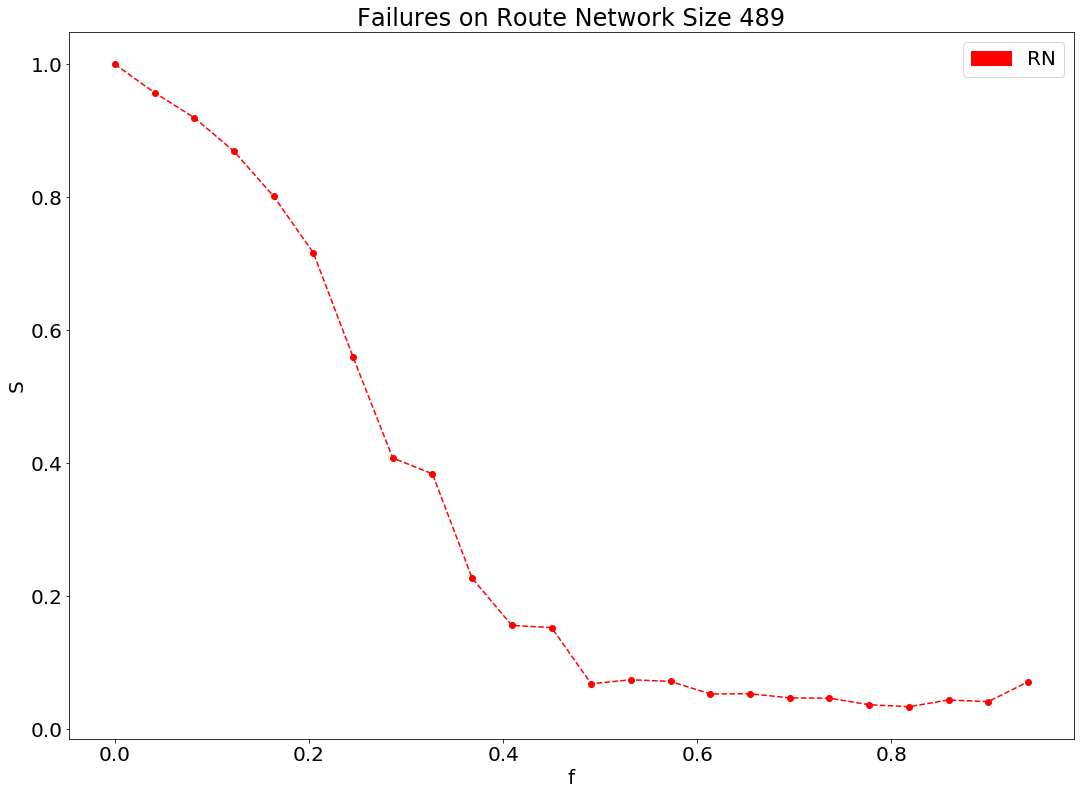

---- Starting Experiments ---- 
100%|███████████████████████████████████████████████████████████████████████████████| 464/464 [00:01<00:00, 461.45it/s]
---- Experiments Finished ---- 


--Experiments Finished--


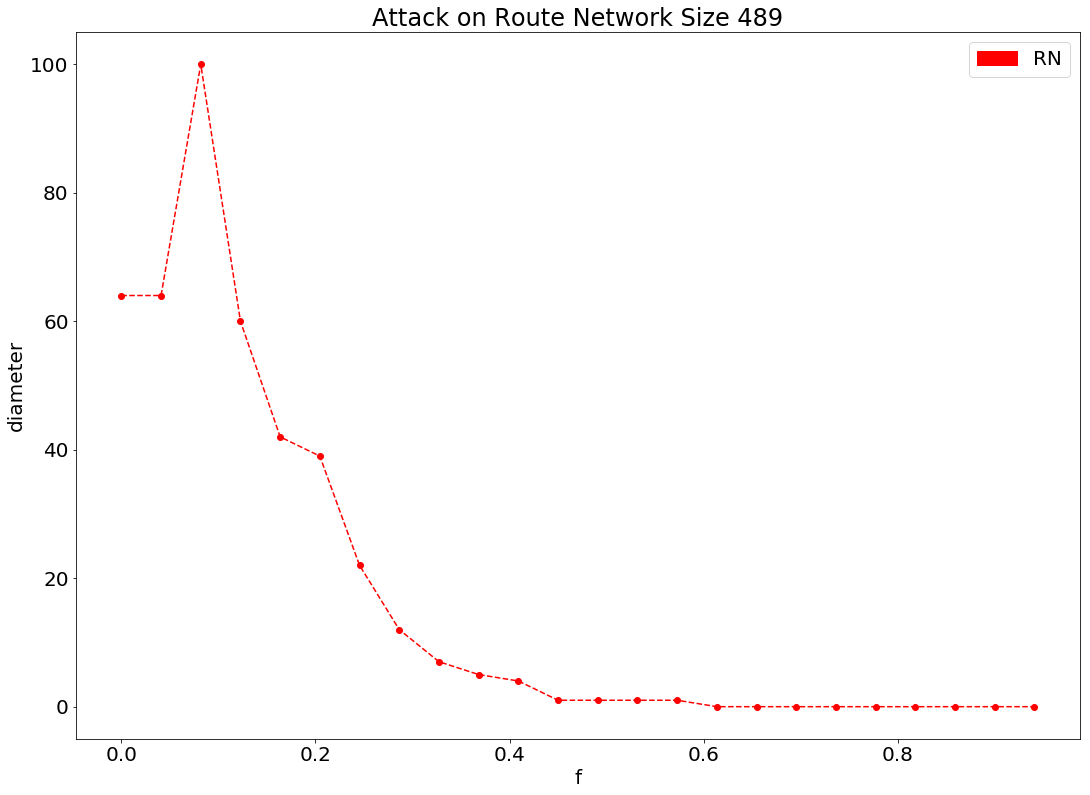

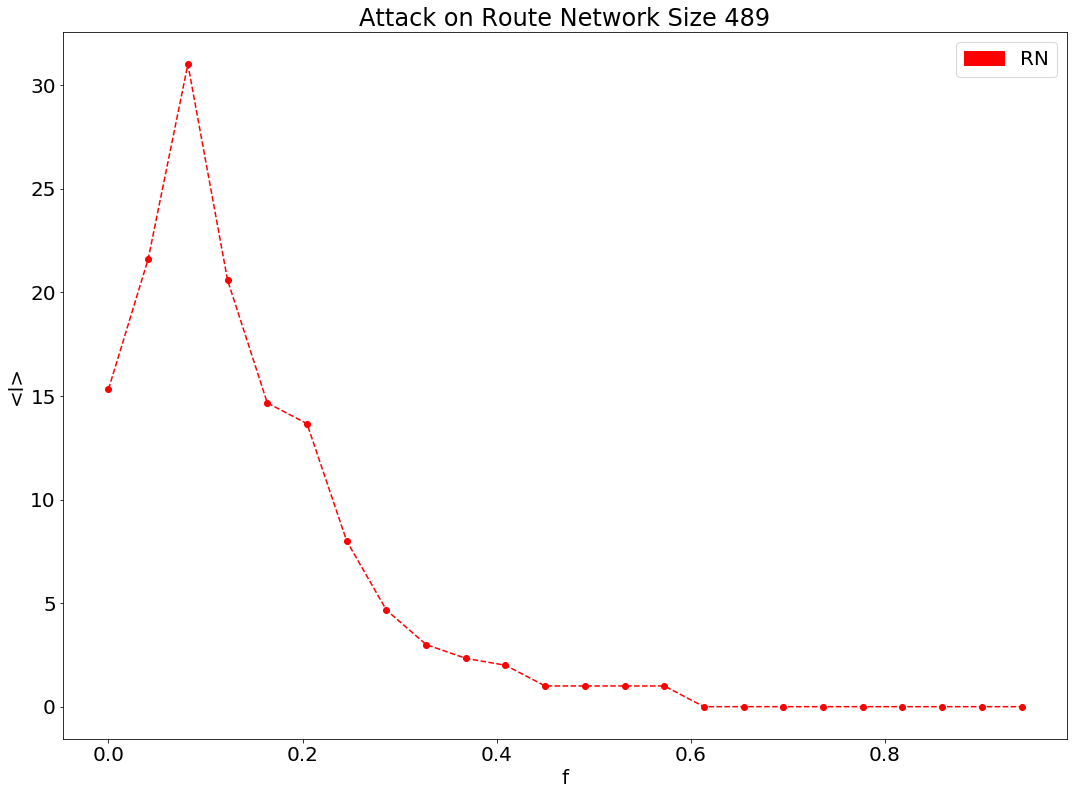

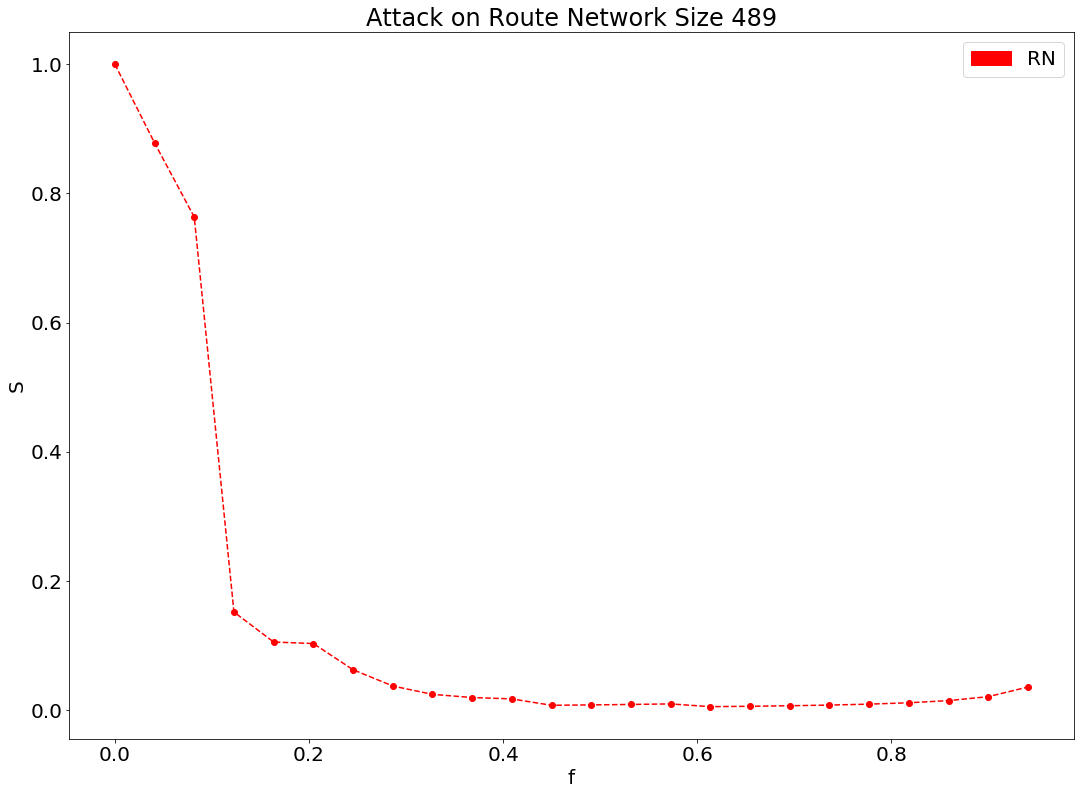

In [119]:
generate_route_generator_analytics(df_stop,df_route,0.95)